In [1]:
import warnings
from ultralytics import YOLO
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.ablation_cam import AblationCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image
import random
from PIL import Image

In [2]:
def parse_detections(detections):
    boxes, colors, names = [], [], []    

    for i in range(len(detections["xmin"])):
        confidence = float(detections["confidence"][i])
        if confidence < 0.2:
            continue
        xmin = int(float(detections["xmin"][i]))
        ymin = int(float(detections["ymin"][i]))
        xmax = int(float(detections["xmax"][i]))
        ymax = int(float(detections["ymax"][i]))
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names
def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes
def printout(outputs):
    plt.figure(figsize=(20, 20))
    for i in range(len(outputs)):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(outputs[i] /255, cmap="gray")
        plt.axis("off")
def get_image(image_path):
    img = np.array(Image.open(image_path))
    img = cv2.resize(img, (640, 640))
    return img

In [3]:
def camtest(image_path):
    img = get_image(image_path)
    rgb_img = img.copy()
    img = img.astype(np.float32) / 255.0
    results = model([rgb_img], verbose=False)
    boxes = results[0].boxes
    columns = ['xmin', 'ymin',	'xmax', 'ymax',	'confidence', 'class', 'name']
    bbox = boxes.xyxy[0].cpu().numpy()
    conf = float(boxes.conf.cpu().numpy())
    cls = int(boxes.cls[0])
    name = (results[0].names[int(boxes.cls[0])])
    print("Confidence:", conf)
    print("Class: ", name)
    data = np.array([bbox[0],bbox[1],bbox[2],bbox[3], conf, cls, name ])
    detections = pd.DataFrame([data], columns=columns)
    boxes, colors, names = parse_detections(detections)
    detection = results[0].plot()
    cam = EigenCAM(model, target_layers)
    grayscale_cam = cam(rgb_img)[0, :, :]
    g_scale = np.stack([grayscale_cam] * 3, axis=2)
    g_scale = np.array(g_scale) *255
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
    return detection, cam_image, g_scale, renormalized_cam_image
    

In [4]:
def replacepixel(img, mask, percentile_value, task):
    mask = mask *255
    mask = mask.astype(np.uint8)
    image = Image.fromarray(img)
    mask = Image.fromarray(mask)
    # percentile_value = 100 - percentile_value
    mask_intensity = np.percentile(mask, percentile_value)
    # Get pixel access objects
    pixel_data = image.load()
    mask_data = mask.load()
    pixel_data = image.load()
    mask_data = mask.load()
    modified_mask = mask.copy()
    modified_mask_data = modified_mask.load()
    width, height = image.size
    mask_intensity_values = [(mask_r + mask_g + mask_b) / 3 for mask_r, mask_g, mask_b in mask.getdata()]
    if (task == 'mean'):
        mean_r = np.mean(img[:, :, 0])
        mean_g = np.mean(img[:, :, 1])
        mean_b = np.mean(img[:, :, 2])
    for x in range(width):
        for y in range(height):
            mask_intensity_value = mask_intensity_values[y * width + x]

            if mask_intensity_value <= mask_intensity:
                if(task == 'random'):
                    new_r = random.randint(0, 255)
                    new_g = random.randint(0, 255)
                    new_b = random.randint(0, 255)
                    modified_mask_data[x, y] = (new_r, new_g, new_b)
                    pixel_data[x, y] = (new_r, new_g, new_b) #random
                elif(task == 'mean'):
                    pixel_data[x, y] = (int(mean_r), int(mean_g), int(mean_b)) #mean
                elif(task == "remove"):
                    r, g, b = pixel_data[x, y]
                    mask_r, mask_g, mask_b = mask_data[x, y]
                    
                    new_r = r * (mask_r / 255) 
                    new_g = g * (mask_g / 255)  
                    new_b = b * (mask_b / 255)  
                    modified_mask_data[x, y] = (int(new_r), int(new_g), int(new_b))
                    pixel_data[x, y] = (int(new_r), int(new_g), int(new_b))

    # Convert the modified Pillow Image back to a numpy array
    modified_image = np.array(image)
    modified_mask = np.array(modified_mask)
    return modified_image, modified_mask
    

In [5]:
def perturbation(img, mask, percentile, task):
    results = model(img, verbose=False, max_det=1)
    boxes = results[0].boxes
    original = results[0].plot()
    conf = float(boxes.conf.cpu().numpy())
    # data = results[0].boxes.data.cpu().numpy()
    # print(data)
    if(task == "remove"):
        perturbed, _ = replacepixel(img, mask, percentile, task)
    if(task == "mean"):
        perturbed, _ = replacepixel(img, mask, percentile, task)
    if(task == "random"):
        perturbed, _ = replacepixel(img, mask, percentile, task)
    results = model([perturbed], max_det=1)
    # data = results[0].boxes.data.cpu().numpy()
    # print(data)
    new = results[0].plot()
    boxes = results[0].boxes
    conf_incr =  float(boxes.conf.cpu().numpy()) - conf
    out = np.stack((original, new), axis=0) 
    return out, conf_incr

In [6]:
def invert_grayscale_image(image):
    # Calculate the maximum pixel value for the grayscale image (usually 255 for 8-bit images)
    max_pixel_value = np.max(image)
    
    # Invert the image by subtracting each pixel value from the maximum
    inverted_image = max_pixel_value - image
    
    return inverted_image

In [77]:
# image_path = "/home/antonino/Università/laurea/script test/xai/speedboat.jpg"
image_path = "/home/antonino/Università/laurea/script test/xai/ferry.png"
img = np.array(Image.open(image_path))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = img.astype(np.float32) / 255.0
#model = YOLO('/home/antonino/Università/porto/train/ModelloTotale/weights/best.pt')
model = YOLO('/home/antonino/Università/porto/train/ModelloVisibile/weights/best.pt')
#model = YOLO('yolov8n.pt')
COLORS = np.random.uniform(0, 255, size=(len(model.names), 3))


In [78]:
results = model(rgb_img, verbose=False)
boxes = results[0].boxes
# data = results[0].boxes.data.cpu().numpy()

In [50]:
import pandas as pd


columns = ['xmin', 'ymin',	'xmax', 'ymax',	'confidence', 'class', 'name']
bbox = boxes.xyxy[0].cpu().numpy()
conf = float(boxes.conf.cpu().numpy())
cls = int(boxes.cls[0])
name = (results[0].names[int(boxes.cls[0])])
data = np.array([bbox[0],bbox[1],bbox[2],bbox[3], conf, cls, name ])
detections = pd.DataFrame([data], columns=columns)

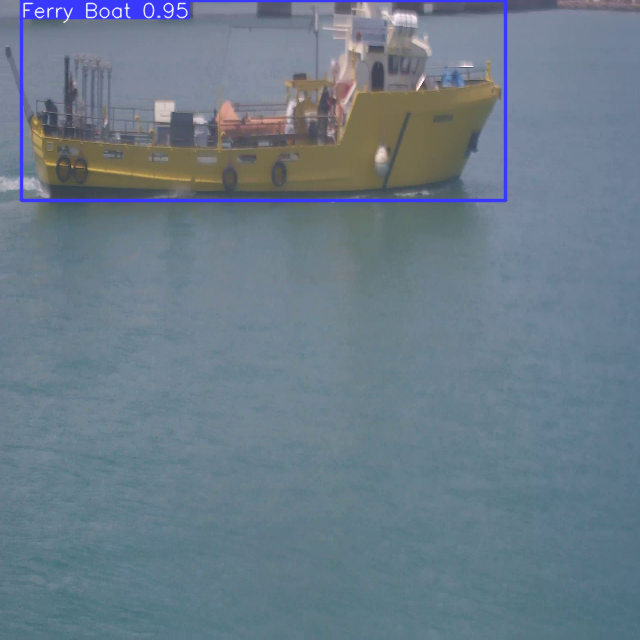

In [51]:
boxes, colors, names = parse_detections(detections)
annotated_frame = results[0].plot()
Image.fromarray(annotated_frame)

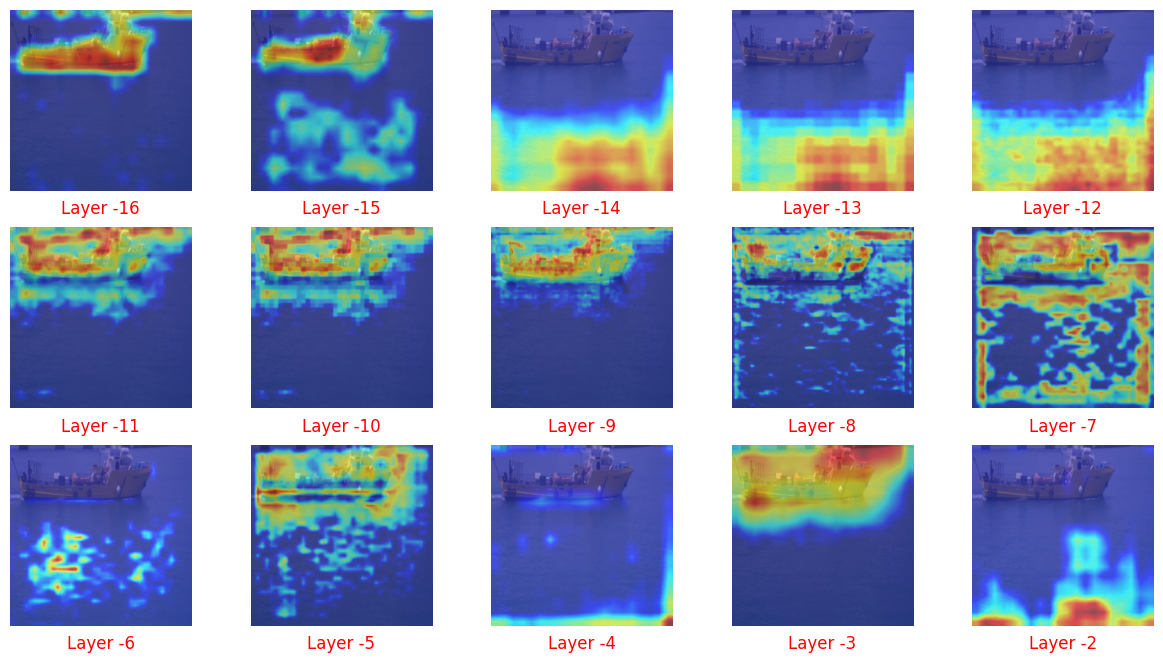

In [52]:
plt.figure(figsize=(15, 8))
u = 0
for i in range(16,1,-1):
   
    target_layers = [model.model.model[-(i)]]
    cam = EigenCAM(model, target_layers)
    grayscale_cam = cam(rgb_img)[0, :]
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    #print(cam_image.shape)
    ax = plt.subplot(3, 5, u + 1)
    u += 1
    #print(u)
    plt.imshow(cam_image)
    plt.text(0.5, -0.1, f'Layer -{i}', transform=ax.transAxes,
            fontsize=12, ha='center', va='center', color='red')
    plt.axis("off")

In [53]:
# YOLOv8.0n backbone
# backbone:
#   # [from, repeats, module, args]
#   - [-1, 1, Conv, [64, 3, 2]]  # 0-P1/2
#   - [-1, 1, Conv, [128, 3, 2]]  # 1-P2/4
#   - [-1, 3, C2f, [128, True]]
#   - [-1, 1, Conv, [256, 3, 2]]  # 3-P3/8
#   - [-1, 6, C2f, [256, True]]
#   - [-1, 1, Conv, [512, 3, 2]]  # 5-P4/16
#   - [-1, 6, C2f, [512, True]]
#   - [-1, 1, Conv, [1024, 3, 2]]  # 7-P5/32  #16
#   - [-1, 3, C2f, [1024, True]] #15
#   - [-1, 1, SPPF, [1024, 5]]  # 14

# # YOLOv8.0n head
# head:
#   - [-1, 1, nn.Upsample, [None, 2, 'nearest']] 
#   - [[-1, 6], 1, Concat, [1]]  # cat backbone P4
#   - [-1, 3, C2f, [512]]  # 11

#   - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
#   - [[-1, 4], 1, Concat, [1]]  # cat backbone P3
#   - [-1, 3, C2f, [256]]  # 8 (P3/8-small)

#   - [-1, 1, Conv, [256, 3, 2]]
#   - [[-1, 12], 1, Concat, [1]]  # cat head P4
#   - [-1, 3, C2f, [512]]  # 5 (P4/16-medium)

#   - [-1, 1, Conv, [512, 3, 2]]
#   - [[-1, 9], 1, Concat, [1]]  # cat head P5
#   - [-1, 3, C2f, [1024]]  # 2 (P5/32-large)

#   - [[15, 18, 21], 1, Detect, [nc]]  # Detect(P3, P4, P5) 1

target_layers = [model.model.model[-3]]

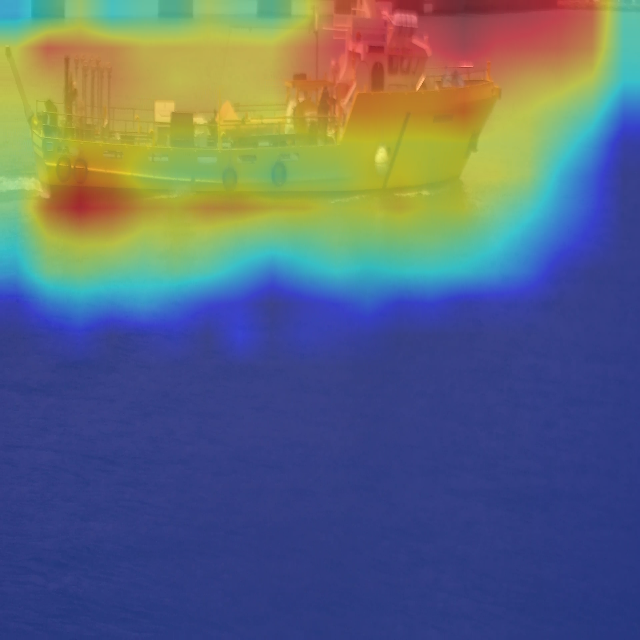

In [54]:
cam = EigenCAM(model, target_layers)
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

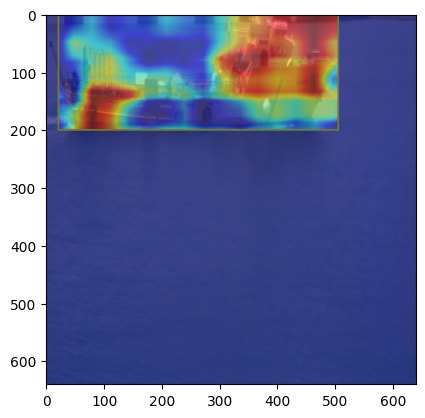

In [55]:
renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)
plt.imshow(renormalized_cam_image)

(-0.5, 639.5, 639.5, -0.5)

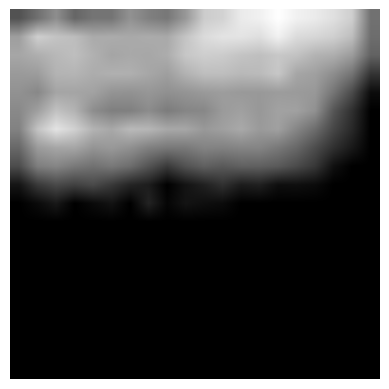

In [56]:
g_scale = np.stack([grayscale_cam] * 3, axis=2)
plt.imshow(g_scale)
plt.axis("off")

The confidence increase:  -0.016386985778808594


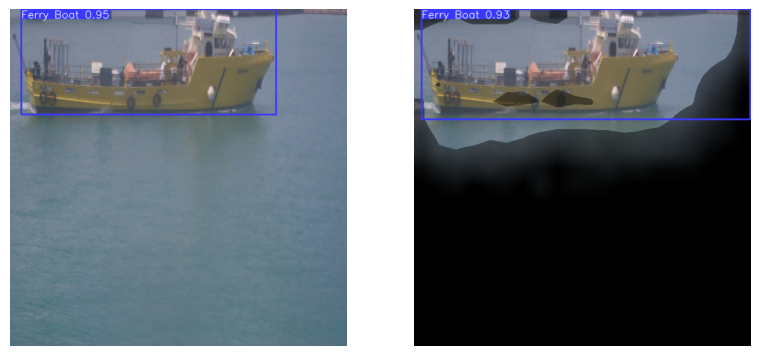

In [57]:
### MORF Removing the highest attention pixels first

out, conf_inc  = perturbation(rgb_img, g_scale, 70, "remove")
print("The confidence increase: ", conf_inc)
printout(out)

The confidence increase:  -0.368948757648468


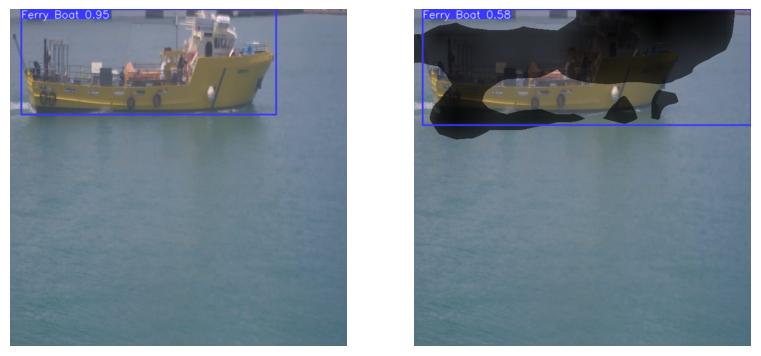

In [76]:
## LERF Removing the least attention pixels first 
inverted_image = invert_grayscale_image(grayscale_cam)
inv_scale = np.stack([inverted_image] * 3, axis=2)
out, conf_inc  = perturbation(rgb_img, inv_scale, 20, "remove")
print("The confidence increase: ", conf_inc)
printout(out)

The confidence increase:  0.0033126473426818848


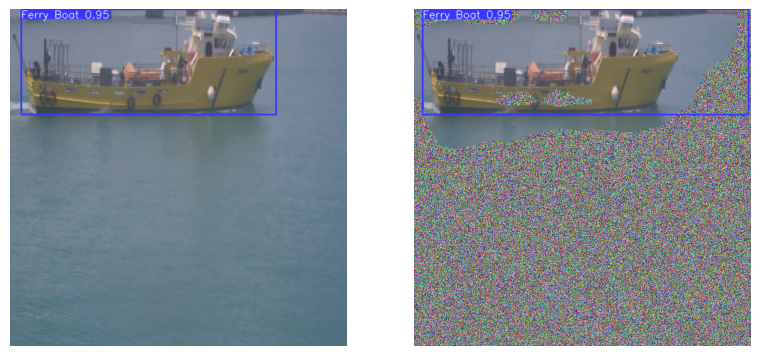

In [60]:
## Replacing pixels that need to be deleted, by random values

out, conf_inc  = perturbation(rgb_img, g_scale, 70, "random")
print("The confidence increase: ", conf_inc)
printout(out)

The confidence increase:  -0.0018483400344848633


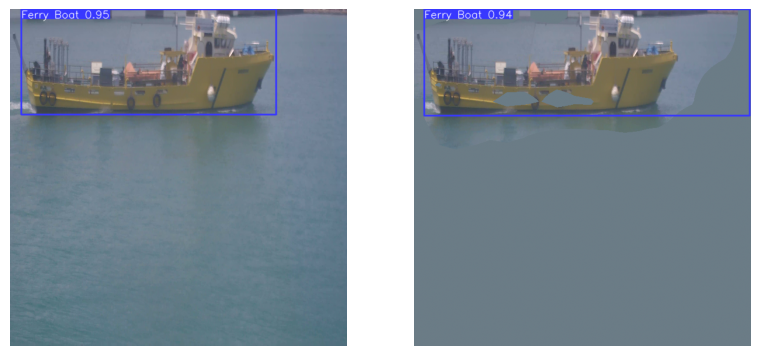

In [63]:
## Replacing pixels that need to be deleted by the mean (for R,G,B separately) in the image

out, conf_inc  = perturbation(rgb_img, g_scale, 70, "mean")
print("The confidence increase: ", conf_inc)
printout(out)

### TESTS ###

Confidence: 0.6510059833526611
Class:  Small Motor Boat


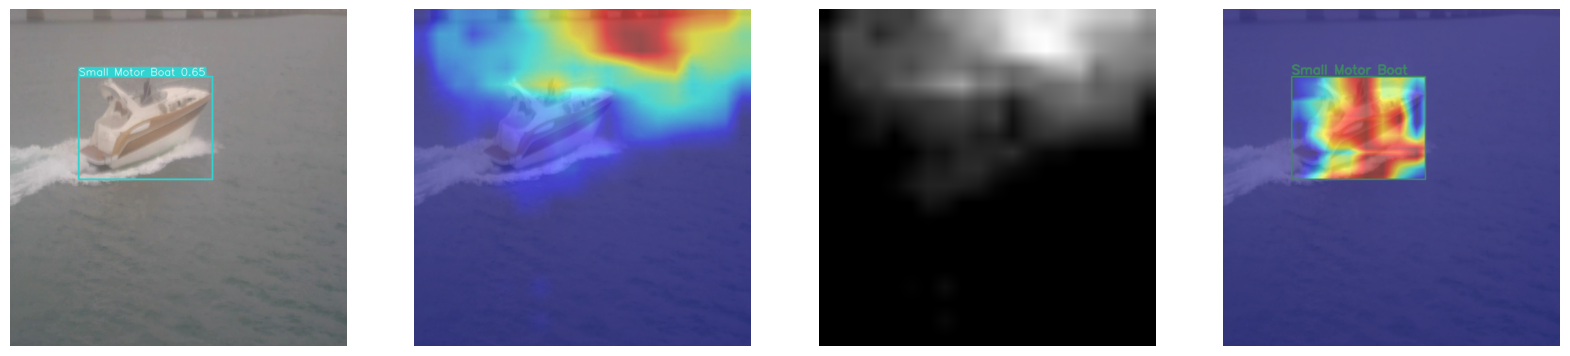

In [64]:
image_path = "/home/antonino/Università/laurea/script test/xai/speedboat.jpg"
outputs = np.stack(camtest(image_path), axis=0)
printout(outputs)

Confidence: 0.9455952644348145
Class:  Ferry Boat


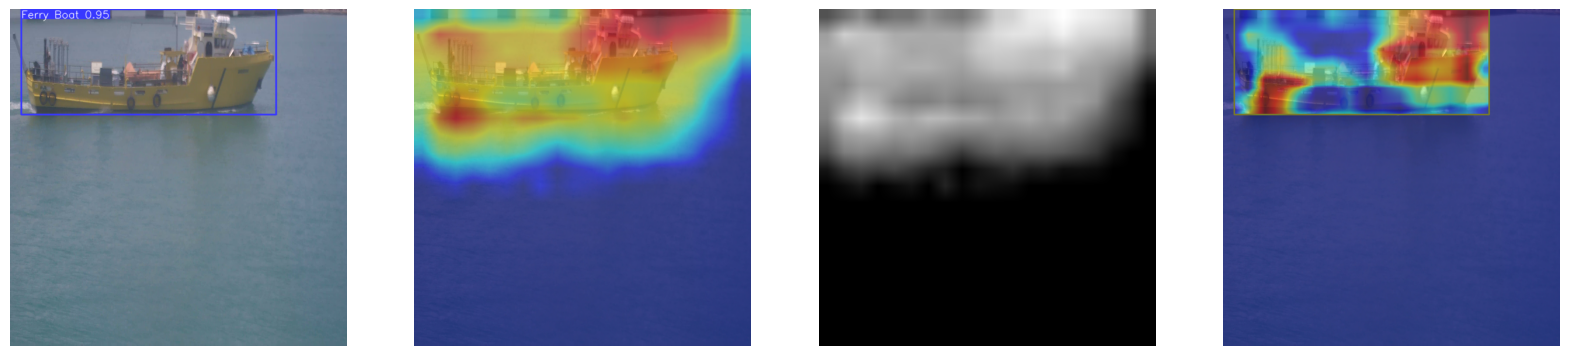

In [65]:
image_path = "/home/antonino/Università/laurea/script test/xai/ferry.png"
outputs = np.stack(camtest(image_path), axis=0)
printout(outputs)


The confidence increase:  -0.021180033683776855


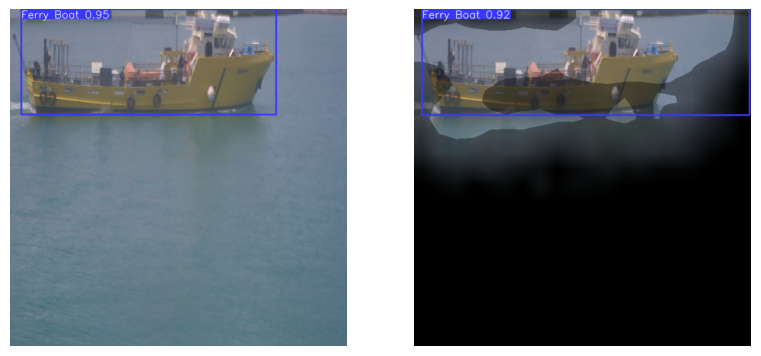

In [66]:
img = get_image(image_path)
out, conf_inc  = perturbation(img, outputs[2] /255, 80, "remove")
print("The confidence increase: ", conf_inc)
printout(out)

Confidence: 0.757239580154419
Class:  Small Motor Boat


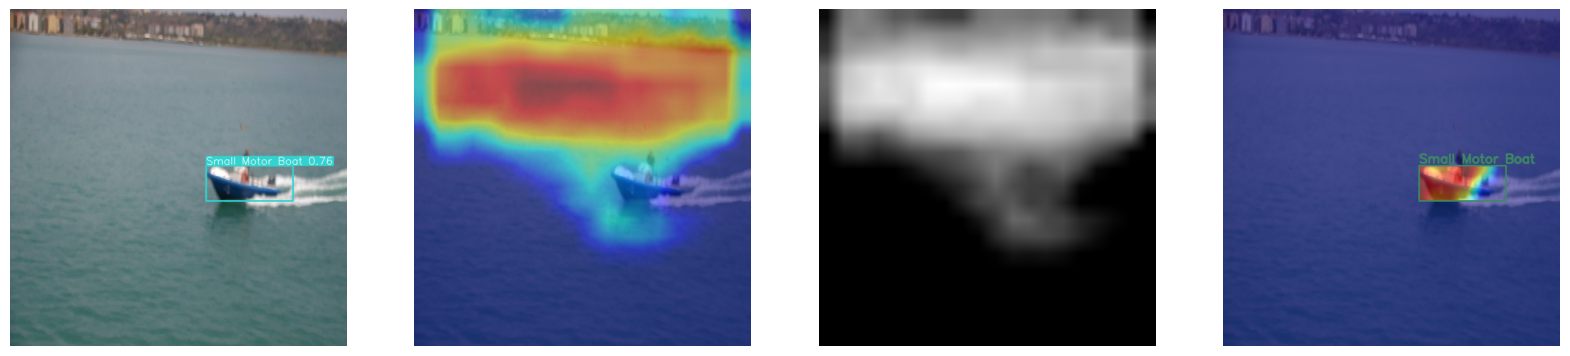

In [67]:
image_path = "/home/antonino/Università/laurea/script test/xai/smalmotor.png"
outputs = np.stack(camtest(image_path), axis=0)
printout(outputs)

The confidence increase:  -0.31164172291755676


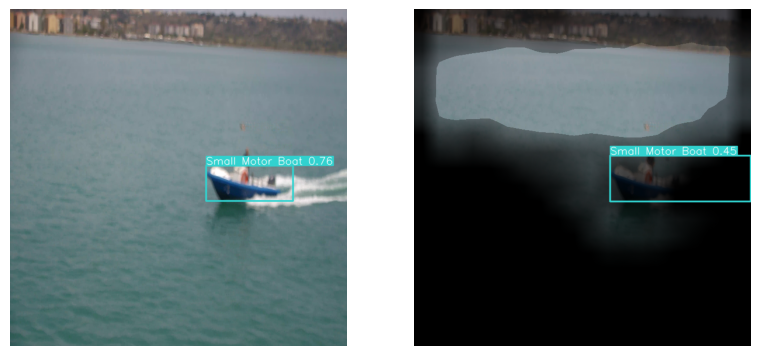

In [68]:
img = get_image(image_path)
out, conf_inc  = perturbation(img, outputs[2] /255, 80, "remove")
print("The confidence increase: ", conf_inc)
printout(out)

Confidence: 0.9598058462142944
Class:  Sail Boat


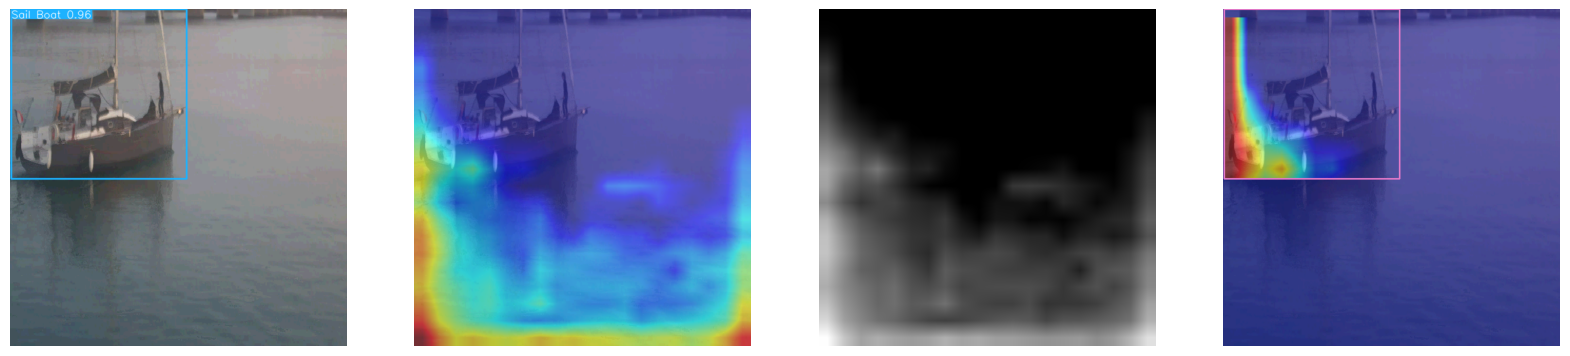

In [69]:
image_path = "/home/antonino/Università/laurea/script test/xai/sail.png"
outputs = np.stack(camtest(image_path), axis=0)
printout(outputs)

The confidence increase:  -0.34910523891448975


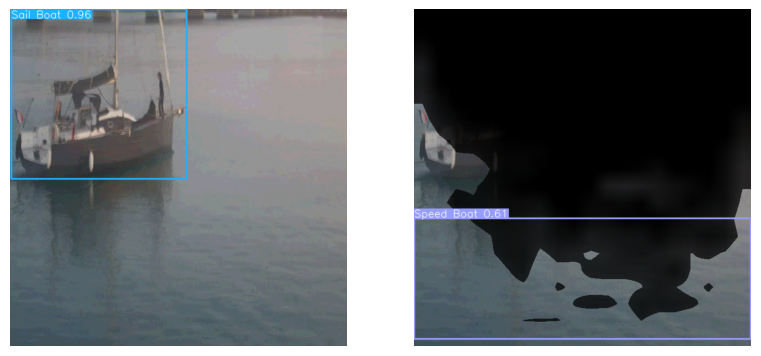

In [72]:
img = get_image(image_path)
out, conf_inc  = perturbation(img, outputs[2] /255, 70, "remove")
print("The confidence increase: ", conf_inc)
printout(out)

Confidence: 0.5507930517196655
Class:  Small Motor Boat


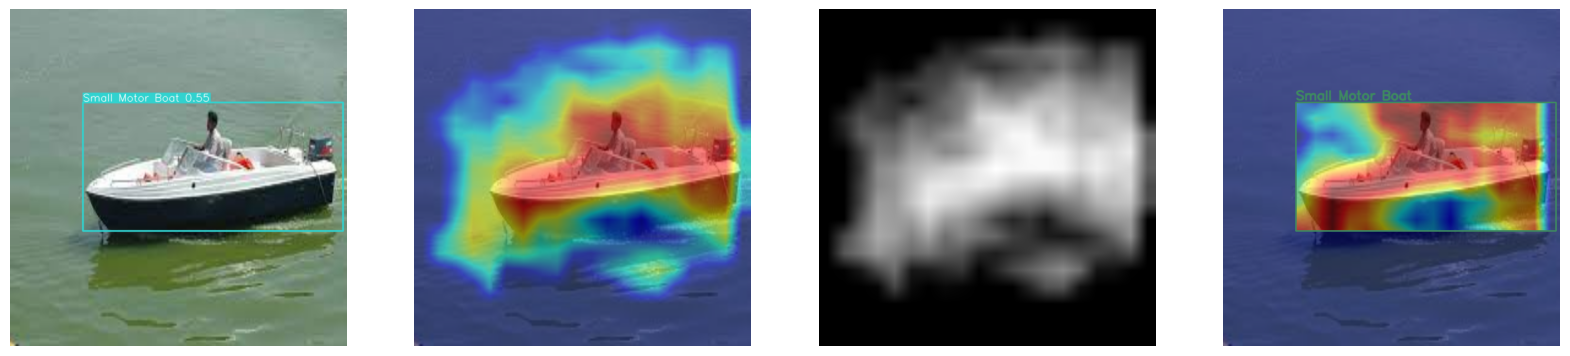

In [73]:
image_path = "/home/antonino/Università/laurea/script test/xai/boat.jpeg"
outputs = np.stack(camtest(image_path), axis=0)
printout(outputs)

The confidence increase:  0.001536548137664795


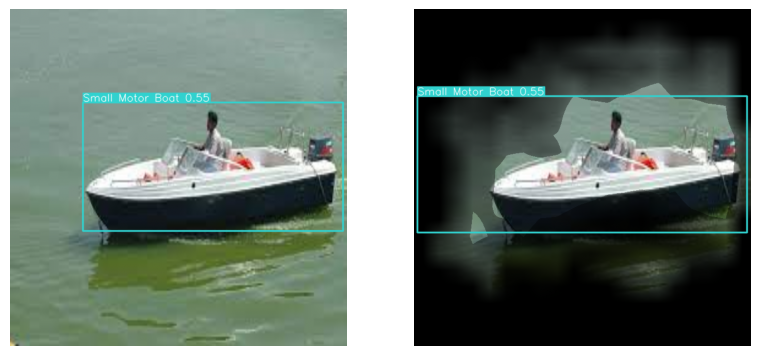

In [74]:
img = get_image(image_path)
out, conf_inc  = perturbation(img, outputs[2] /255, 80, "remove")
print("The confidence increase: ", conf_inc)
printout(out)